Initialize parameters to a sin wave of the form:

y = $A \sin{\nu x}$

We will also create a perturbed set of data that is sampled from this sin wave but has an added error, yerr.

In [1]:
import numpy as np
Nobs = 100 ## Number of sampled points.

x = np.sort(10 * np.random.rand(Nobs)) ## randomly sampled points between 0 and 10.
amp_true = 2.0 ## True value of A
freq_true = 1.0 ## True value of nu
eps_true = 0.5 ## True value of the magnitude of the error.

y_true = amp_true * np.sin(freq_true * x) ## True values of y
yerr = np.random.normal(0, eps_true, size=Nobs) ## Error to be added to y_true
y_obs = amp_true * np.sin(freq_true * x) + yerr ## Observational data, y_obs, with added error yerr.

Plot the data!

Text(0, 0.5, 'Y Pred')

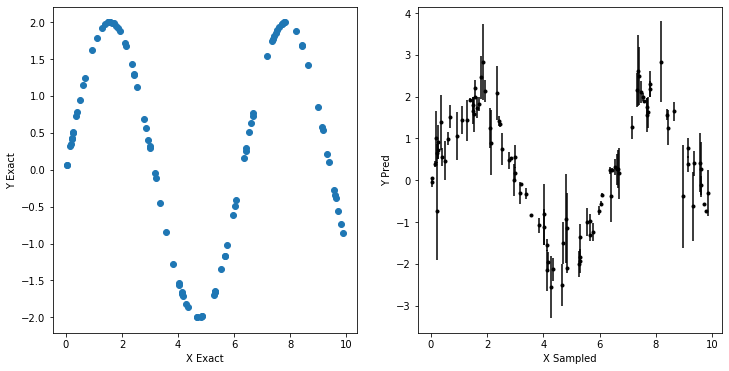

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt 
plt.figure(figsize=(12,6)) 
plt.subplot(1,2,1)
plt.scatter(x, y_true)
plt.xlabel('X Exact')
plt.ylabel('Y Exact')
plt.subplot(1,2,2)
plt.errorbar(x, y_obs, yerr=yerr, fmt=".k")
plt.xlabel('X Sampled')
plt.ylabel('Y Pred')

Text(0, 0.5, 'Y')

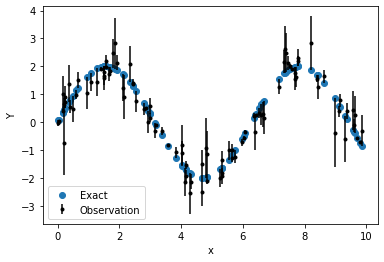

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt 
plt.scatter(x, y_true, label = 'Exact')
plt.errorbar(x, y_obs, yerr=yerr, fmt=".k", label = 'Observation')
plt.legend()
plt.xlabel('x')
plt.ylabel('Y')

We will now define a prior that provides an initial guess at the distribution of the parameters we are trying to find. 

We also define an error function that we will try to minimize. In this case, we are using the log of a gaussian.

In [4]:
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    amp, freq = p
    # We're using only uniform priors, and only eps has a lower bound
    if amp <= 0 or amp > 10:
        return -np.inf
    if freq <= 0:
        return -np.inf
    return 0

def lnlike(p, x, y):
    amp, freq = p
    model = amp * np.sin(freq * x)
    # the likelihood is sum of the lot of normal distributions
    denom = np.sqrt(2*np.pi*yerr**2.0)
    lp = np.sum((-(y - model)**2.0/(2*yerr**2.0)) - np.log(denom))
    return lp

def lnprob(p, x, y):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x, y)

Perform a least squares fit using SciPy. Provide a model with parameters t[0] and t[1]. 

In [5]:
import scipy.optimize as opt
from scipy.optimize import leastsq
optimize_func = lambda t: t[0]*np.sin(t[1]*x) - y_obs
result = leastsq(optimize_func, [5,1])[0]

Plot the resulting function from the optimizer and the true function. Also plotting the relative error in log scale.

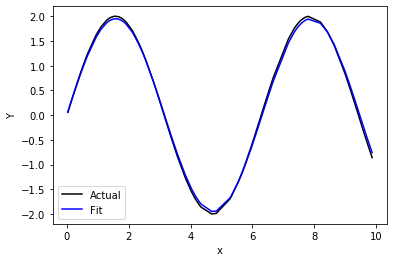

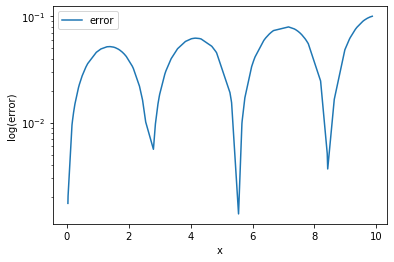

In [6]:
y_perfect = amp_true * np.sin(freq_true * x)
y_opt = result[0] * np.sin(result[1] * x)

plt.plot(x, y_perfect, 'k', label = 'Actual')
plt.plot(x, y_opt,'b', label = 'Fit')
plt.legend()
plt.xlabel('x')
plt.ylabel('Y')
plt.show()

plt.semilogy(x,np.abs(y_perfect-y_opt), label = 'error')
plt.legend()
plt.xlabel('x')
plt.ylabel('log(error)')
plt.show()


Now, we will use MCMC to do the same thing - given a noisy dataset and a model, it will make predictions about the parameters.

We begin by initializing 50 walkers that will explore 2 dimensions. We then make initial guesses for the dimensions. These represent the parameters of the model. In our case, those are the amplitude and frequency. We then initialize our walkers to explore the parameter space around each guess. 

In [7]:
Nwalker,Ndim = 50,2
initial = [5,1]
p0 = [initial+1.e-4*np.random.randn(Ndim) for i in range(Nwalker)]

Import emcee to do the MCMC for us. 

Run an Ensemble Sampler which will take each walker and initialize it at a value near our initial guess. The walkers will then explore the parameter space and try to minimize the error between the model and the guess. The walkers will move into the direction of minimal error.

In [8]:
import emcee
sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,
                                args=(x,y_true))
pos,prob,state = sampler.run_mcmc(p0, 1000, progress = True)

100%|██████████| 1000/1000 [00:01<00:00, 522.61it/s]


Plotting the walkers as they explore the parameter space.

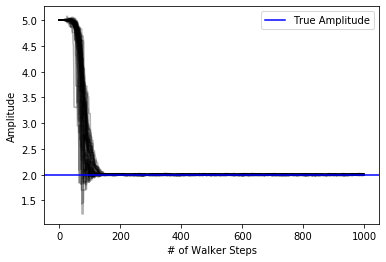

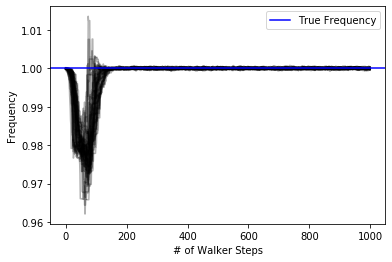

In [9]:
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.axhline(amp_true, color='blue', label = 'True Amplitude')
plt.ylabel('Amplitude')
plt.xlabel('# of Walker Steps')
plt.legend()
plt.show()

res=plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
plt.axhline(freq_true, color='blue', label = "True Frequency")
plt.xlabel('# of Walker Steps')
plt.ylabel('Frequency')
plt.legend()
plt.show()

"\nfig = corner.corner(flat_samples,bins=50,color='C0',smooth=0.5,plot_datapoints=False,plot_density=True,plot_contours=True,fill_contour=False,show_titles=True,labels=['amp','freq'], \n                truths=[amp_true, freq_true])\n"

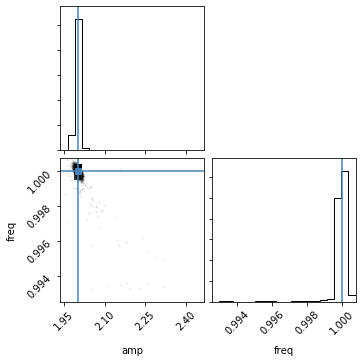

In [10]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
import corner

tmp = corner.corner(flat_samples, labels=['amp','freq'], 
                truths=[amp_true, freq_true])
'''
fig = corner.corner(flat_samples,bins=50,color='C0',smooth=0.5,plot_datapoints=False,plot_density=True,plot_contours=True,fill_contour=False,show_titles=True,labels=['amp','freq'], 
                truths=[amp_true, freq_true])
'''

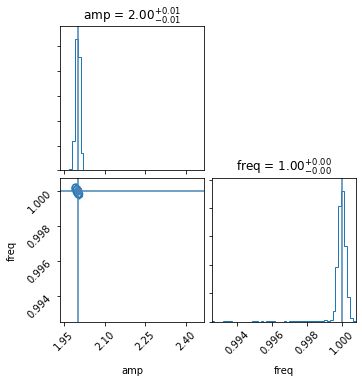

In [11]:
fig = corner.corner(flat_samples,bins=50,color='C0',smooth=0.5,plot_datapoints=False,plot_density=True,plot_contours=True,fill_contour=False,show_titles=True,labels=['amp','freq'], 
                truths=[amp_true, freq_true])